<a href="https://colab.research.google.com/github/reynoso811/Image-Classification-Pneumonia-X-rays-/blob/main/Phase_04_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Pre-trained Keras VGG16 Model

# Importing libraries

In [ ]:
import numpy as np
import pandas as pd 
import random as rn

# tensorflow
import tensorflow.random as tfr
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Lambda, Input
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns

from skimage import color, exposure
from sklearn.metrics import classification_report

import os
import cv2

# Setting the same seed for repeatability

seed = 0

np.random.seed(seed) 
rn.seed(seed)
tfr.set_seed(seed)

# Display graphs in a Jupyter
%matplotlib inline

print("Imported")

Imported


In [ ]:
# Google Drive connection

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read the data

In [ ]:
# Create a path to the root folder and path to specific folders

data_path = '/content/drive/MyDrive/Phase_04_project/chest_xray/chest_xray/'
data_path

train_path = data_path + 'train/'
test_path = data_path + 'test/'
val_path = data_path + 'val/'

In [ ]:
# Optimal image size for modeling

img_size = [200, 200]
#img_size = 200

In [ ]:
# Custom function to read data from folders
# Returns numpy array [img, label]

def read_data(data_paths):
    for data_path in data_paths:
        labels = ['PNEUMONIA', 'NORMAL']
        images = []
        y = []
        for label in labels:
            curr_path = data_path + label
            for img in os.listdir(curr_path):
                if ('DS' not in img):
                    image_path = os.path.join(curr_path, img)
                    image =  cv2.resize(cv2.imread(image_path), (img_size, img_size))
                    if image is not None:
                        images.append([image, label])
                
    images = np.asarray(images)
    return images

In [ ]:
train = read_data([train_path])
test = read_data([val_path, test_path])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
# Shuffle the data

for i in range(10):
    np.random.shuffle(train)
    np.random.shuffle(test)

In [ ]:
# Create data frame for visualization

train_df = pd.DataFrame(train, columns=['image', 'label'])
test_df = pd.DataFrame(test, columns = ['image', 'label'])

In [ ]:
def lung_condition(label):
    if label == 'NORMAL':
        return 0
    else:
        return 1

In [ ]:
# Function for dividing data into arrays X and y

def splitdata(data):
    X = []
    y = []
    for i, (val, label) in enumerate(data):
        X.append(val)
        y.append(lung_condition(label))
    return np.array(X), np.array(y)

In [ ]:
# Split the data


np.random.shuffle(train)
np.random.shuffle(test)
X_train, y_train = splitdata(train)
X_test, y_test = splitdata(test)


# Modeling

In [ ]:
# Add preprocessing layer to the front of VGG16

# Change img_size before running this cell

vgg = VGG16(input_shape = img_size + [3], 
            weights = 'imagenet',
            include_top=False)


# Don't train existing weights

for layer in vgg.layers:
  layer.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
# Adding more layers in our VGG16 model

categories = ["NORMAL", "PNEUMONIA"]

x = Flatten()(vgg.output)
x = Dense(1000, activation='relu')(x)

# This is the Last Layer with softmax activation for binary outputs

prediction = Dense(len(categories), activation='softmax')(x)

In [ ]:
# Create a model object

model = Model(inputs=vgg.input, outputs=prediction)

# View the structure of the model

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [ ]:
# Tell the model what cost and optimization method to use

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

## Preparing images for the model

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (200, 200),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (200, 200),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Fit the model

r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/5
163/163 [==============================] - 2165s 13s/step - loss: 0.4301 - accuracy: 0.9162 - val_loss: 0.3101 - val_accuracy: 0.8814
Epoch 2/5
163/163 [==============================] - 2126s 13s/step - loss: 0.1486 - accuracy: 0.9427 - val_loss: 0.2778 - val_accuracy: 0.9087
Epoch 3/5
163/163 [==============================] - 2124s 13s/step - loss: 0.1027 - accuracy: 0.9592 - val_loss: 0.3124 - val_accuracy: 0.9038
Epoch 4/5
163/163 [==============================] - 2124s 13s/step - loss: 0.0957 - accuracy: 0.9655 - val_loss: 0.2580 - val_accuracy: 0.9167
Epoch 5/5
163/163 [==============================] - 2122s 13s/step - loss: 0.0978 - accuracy: 0.9626 - val_loss: 0.2436 - val_accuracy: 0.9183


In [ ]:
# Save trained model

model.save('/content/drive/MyDrive/Phase_04_project/vgg16_model_1.h5')

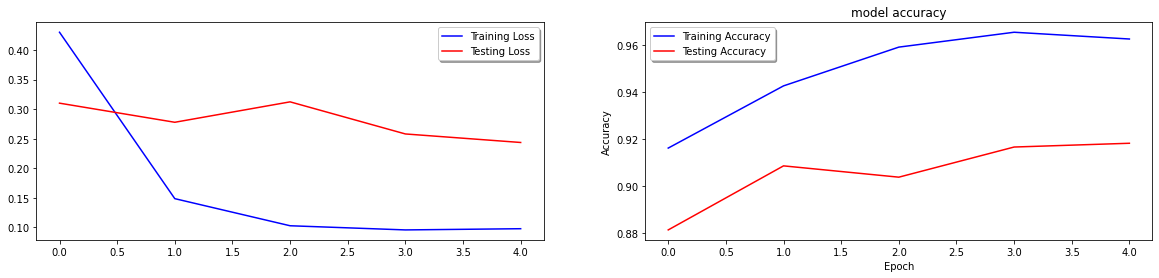

In [ ]:
# Plot the the model

fig, ax = plt.subplots(figsize=(20, 4), nrows=1, ncols=2)

plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

ax[0].plot(r.history['loss'], color='b', label="Training Loss")
ax[0].plot(r.history['val_loss'], color='r', label="Testing Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(r.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(r.history['val_accuracy'], color='r',label="Testing Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# Evaluate

In [ ]:
val_path = '/content/drive/MyDrive/Phase_04_project/chest_xray/chest_xray/val'

In [ ]:
# re-size all the images to a size VGG-16 expects
IMAGE_SIZE = [200, 200]

# Set the batch size
BATCH_SIZE = 32  
NUM_EPOCHS = 5
LEARNING_RATE = 0.0001
NUM_CLASSES = 2 

In [ ]:
# Generate Validation set


validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_set = validation_datagen.flow_from_directory(
    directory = val_path,
    target_size = (200, 200),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 16 images belonging to 2 classes.


In [ ]:
validation_steps = 200

loss0,accuracy0 = model.evaluate(validation_set, steps = validation_steps)

print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

200/200 [==============================] - 6s 205us/step - loss: 0.1247 - accuracy: 0.9375
loss: 0.12
accuracy: 0.94


In [ ]:
# Generate Validation set.
validation_set2 = validation_datagen.flow_from_directory(
    directory = val_path,
    target_size = (224, 224),
    batch_size = 1,
    shuffle=False, 
    seed=42, 
    class_mode="binary"
)

# validation_set2.reset()

Found 16 images belonging to 2 classes.


In [ ]:

val = model.evaluate(validation_set, steps = validation_steps)

print("loss: {:.2f}".format(val[0]))
print("accuracy: {:.2f}".format(val[1]))

200/200 [==============================] - 6s 165us/step - loss: 0.1247 - accuracy: 0.9375
loss: 0.12
accuracy: 0.94


# VGG16 model Summary:

* Best accuracy this pretrained model acheived was ~94%

* The confusion matrix shows that

* The model is overfitting, quite a bit. We can see around Epoch 20 on the Binary Accuracy graph that the model doesn't not improve.

* This model could be improved/tuned by using differnet activation functions, trying different optimizers, including early stopping and different degrees of dropouts.

# Use trained model to make predictions

In [ ]:
# Load the saved trained model


model = load_model('/content/drive/MyDrive/Phase_04_project/vgg16_model_1.h5')

In [ ]:
# Path to images

normal_images_list = glob("/content/drive/MyDrive/Phase_04_project/chest_xray/chest_xray/val/NORMAL/*")

infected_images_list = glob("/content/drive/MyDrive/Phase_04_project/chest_xray/chest_xray/val/PNEUMONIA/*")


In [ ]:
from PIL import Image
from glob import glob

In [ ]:
# Function to read images, predict, and dislpay X-ray

def predict_image(image_path):
    img = image.load_img(image_path, target_size=(200, 200))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    img_data = preprocess_input(x)
    classes = model.predict(img_data)
    
    pred_class = classes[0]
    
    display(img)

    if pred_class[0] > pred_class[1]:
        print("Normal Xray")
    else:
        print("Pneumonia XRay")

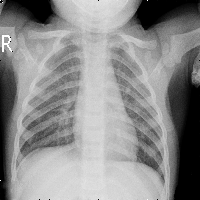

Normal Xray


In [ ]:
ramdom_noraml_img = normal_images_list[np.random.randint(len(normal_images_list))]

predict_image(ramdom_noraml_img)

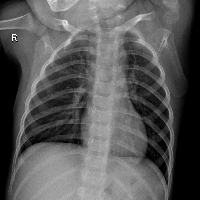

Pneumonia XRay


In [ ]:
ramdom_infected_img = normal_images_list[np.random.randint(len(infected_images_list))]

predict_image(ramdom_infected_img)
